# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import itertools #for ARIMA
import statsmodels.api as sm #to forcast timeseries data

# Time Series forcasing for office supplies sales

In [27]:
!pip install xlrd

   ---------------------------------------- 0.0/96.6 kB ? eta -:--:--
   ---- ----------------------------------- 10.2/96.6 kB ? eta -:--:--
   ----------------------------- ---------- 71.7/96.6 kB 787.7 kB/s eta 0:00:01
   ---------------------------------------- 96.6/96.6 kB 1.1 MB/s eta 0:00:00


In [141]:
# load data



sales_data = pd.read_excel(r"C:\Users\Zubeen\Desktop\Data\sample_-_superstore (1).xls")

In [143]:
sales_data.head()

Row ID        Order ID Order Date  Ship Date       Ship Mode Customer ID  \
0       1  CA-2016-152156 2016-11-08 2016-11-11    Second Class    CG-12520   
1       2  CA-2016-152156 2016-11-08 2016-11-11    Second Class    CG-12520   
2       3  CA-2016-138688 2016-06-12 2016-06-16    Second Class    DV-13045   
3       4  US-2015-108966 2015-10-11 2015-10-18  Standard Class    SO-20335   
4       5  US-2015-108966 2015-10-11 2015-10-18  Standard Class    SO-20335   

     Customer Name    Segment        Country             City  ...  \
0      Claire Gute   Consumer  United States        Henderson  ...   
1      Claire Gute   Consumer  United States        Henderson  ...   
2  Darrin Van Huff  Corporate  United States      Los Angeles  ...   
3   Sean O'Donnell   Consumer  United States  Fort Lauderdale  ...   
4   Sean O'Donnell   Consumer  United States  Fort Lauderdale  ...   

  Postal Code  Region       Product ID         Category Sub-Category  \
0       42420   South  FUR-BO-10001798        Furniture    Bookcases   
1       42420   South  FUR-CH-10000454        Furniture       Chairs   
2       90036    West  OFF-LA-10000240  Office Supplies       Labels   
3       33311   South  FUR-TA-10000577        Furniture       Tables   
4       33311   South  OFF-ST-10000760  Office Supplies      Storage   

                                        Product Name     Sales  Quantity  \
0                  Bush Somerset Collection Bookcase  261.9600         2   
1  Hon Deluxe Fabric Upholstered Stacking Chairs,...  731.9400         3   
2  Self-Adhesive Address Labels for Typewriters b...   14.6200         2   
3      Bretford CR4500 Series Slim Rectangular Table  957.5775         5   
4                     Eldon Fold 'N Roll Cart System   22.3680         2   

   Discount    Profit  
0      0.00   41.9136  
1      0.00  219.5820  
2      0.00    6.8714  
3      0.45 -383.0310  
4      0.20    2.5164  

[5 rows x 21 columns]

In [5]:
df = sales_data.copy()

In [7]:
df.info() 
# no missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Row ID         9994 non-null   int64         
 1   Order ID       9994 non-null   object        
 2   Order Date     9994 non-null   datetime64[ns]
 3   Ship Date      9994 non-null   datetime64[ns]
 4   Ship Mode      9994 non-null   object        
 5   Customer ID    9994 non-null   object        
 6   Customer Name  9994 non-null   object        
 7   Segment        9994 non-null   object        
 8   Country        9994 non-null   object        
 9   City           9994 non-null   object        
 10  State          9994 non-null   object        
 11  Postal Code    9994 non-null   int64         
 12  Region         9994 non-null   object        
 13  Product ID     9994 non-null   object        
 14  Category       9994 non-null   object        
 15  Sub-Category   9994 n

In [35]:
df.describe()

Row ID                     Order Date  \
count  9994.000000                           9994   
mean   4997.500000  2016-04-30 00:07:12.259355648   
min       1.000000            2014-01-03 00:00:00   
25%    2499.250000            2015-05-23 00:00:00   
50%    4997.500000            2016-06-26 00:00:00   
75%    7495.750000            2017-05-14 00:00:00   
max    9994.000000            2017-12-30 00:00:00   
std    2885.163629                            NaN   

                           Ship Date   Postal Code         Sales     Quantity  \
count                           9994   9994.000000   9994.000000  9994.000000   
mean   2016-05-03 23:06:58.571142912  55190.379428    229.858001     3.789574   
min              2014-01-07 00:00:00   1040.000000      0.444000     1.000000   
25%              2015-05-27 00:00:00  23223.000000     17.280000     2.000000   
50%              2016-06-29 00:00:00  56430.500000     54.490000     3.000000   
75%              2017-05-18 00:00:00  90008.000000    209.940000     5.000000   
max              2018-01-05 00:00:00  99301.000000  22638.480000    14.000000   
std                              NaN  32063.693350    623.245101     2.225110   

          Discount       Profit  
count  9994.000000  9994.000000  
mean      0.156203    28.656896  
min       0.000000 -6599.978000  
25%       0.000000     1.728750  
50%       0.200000     8.666500  
75%       0.200000    29.364000  
max       0.800000  8399.976000  
std       0.206452   234.260108

In [9]:
# checking unique categories
df['Category'].unique()

array(['Furniture', 'Office Supplies', 'Technology'], dtype=object)

In [7]:
#how many rows per category
df['Category'].value_counts()

Category
Office Supplies    6026
Furniture          2121
Technology         1847
Name: count, dtype: int64

In [13]:
# as the focus is on office supplies so I will extract the rows containing this category
office_supplies = df[df['Category'] == 'Office Supplies']

In [9]:
office_supplies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6026 entries, 2 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Row ID         6026 non-null   int64         
 1   Order ID       6026 non-null   object        
 2   Order Date     6026 non-null   datetime64[ns]
 3   Ship Date      6026 non-null   datetime64[ns]
 4   Ship Mode      6026 non-null   object        
 5   Customer ID    6026 non-null   object        
 6   Customer Name  6026 non-null   object        
 7   Segment        6026 non-null   object        
 8   Country        6026 non-null   object        
 9   City           6026 non-null   object        
 10  State          6026 non-null   object        
 11  Postal Code    6026 non-null   int64         
 12  Region         6026 non-null   object        
 13  Product ID     6026 non-null   object        
 14  Category       6026 non-null   object        
 15  Sub-Category   6026 non-nu

In [61]:
# exploring timestamps 

print(f"Highest Date: {office_supplies['Order Date'].max()}")
print(f"Lowest Date: {office_supplies['Order Date'].min()}")

Highest Date: 2017-12-30 00:00:00
Lowest Date: 2014-01-03 00:00:00


# Data Pre-processing

In [15]:
# dropping unnecessary columns
office_supplies.columns

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit'],
      dtype='object')

In [17]:
data = office_supplies.copy()

In [19]:
col_to_drop = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Quantity', 'Discount', 'Profit']
filtered_data = data.drop(col_to_drop, axis=1)

In [15]:
filtered_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6026 entries, 2 to 9993
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Order Date  6026 non-null   datetime64[ns]
 1   Sales       6026 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 141.2 KB


In [17]:
filtered_data

Order Date    Sales
2    2016-06-12   14.620
4    2015-10-11   22.368
6    2014-06-09    7.280
8    2014-06-09   18.504
9    2014-06-09  114.900
...         ...      ...
9982 2016-09-22   35.560
9984 2015-05-17   31.500
9985 2015-05-17   55.600
9992 2017-02-26   29.600
9993 2017-05-04  243.160

[6026 rows x 2 columns]

In [19]:
filtered_data.info() #no null value

<class 'pandas.core.frame.DataFrame'>
Index: 6026 entries, 2 to 9993
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Order Date  6026 non-null   datetime64[ns]
 1   Sales       6026 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 141.2 KB


In [21]:
office = filtered_data.groupby('Order Date')['Sales'].sum().reset_index() #to combine total sales per order date

In [23]:
office.head()

Order Date    Sales
0 2014-01-03   16.448
1 2014-01-04  288.060
2 2014-01-05   19.536
3 2014-01-06  685.340
4 2014-01-07   10.430

In [25]:
office.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1148 entries, 0 to 1147
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Order Date  1148 non-null   datetime64[ns]
 1   Sales       1148 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 18.1 KB


# Daily Sales Range for Office Supplies

In [208]:
office.describe()

Sales
count   1148.000000
mean     626.347589
std      995.566806
min        1.788000
25%       80.853500
50%      284.455000
75%      744.390000
max    10142.354000

In [25]:
daily_max = office['Sales'].max()
daily_min = office['Sales'].min()
daily_range = daily_max - daily_min

print(f"Daily Office Supplies Sales Range: {round(daily_range, 2)}")

Daily Office Supplies Sales Range: 10140.57


# Indexing with time series data

* To easily filter by time
* For resampling data, like turning daily sales to monthly averages
* Helps with rolling calculations, like moving averages
* Most forecasting models (like ARIMA or Prophet) require a time index to work properly
* Data is easier to visualise and predict

In [27]:
office = office.set_index('Order Date')
office.index

DatetimeIndex(['2014-01-03', '2014-01-04', '2014-01-05', '2014-01-06',
               '2014-01-07', '2014-01-09', '2014-01-10', '2014-01-13',
               '2014-01-16', '2014-01-18',
               ...
               '2017-12-21', '2017-12-22', '2017-12-23', '2017-12-24',
               '2017-12-25', '2017-12-26', '2017-12-27', '2017-12-28',
               '2017-12-29', '2017-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=1148, freq=None)

In [29]:
# using pandas to group the data by the start of each calender month when resampling
# Instead of daily sales , calculating the average sales for each month, using first data as the timestamp
# useful as monthly trends are easier to model and visualise

y = office['Sales'].resample('MS').mean() # 'MS' 'Month Start'

In [20]:
y #per month average

Order Date
2014-01-01     285.357647
2014-02-01      63.042588
2014-03-01     391.176318
2014-04-01     464.794750
2014-05-01     324.346545
2014-06-01     588.774409
2014-07-01     756.060400
2014-08-01     541.879143
2014-09-01    1015.677704
2014-10-01     267.078815
2014-11-01     959.372714
2014-12-01     692.556231
2015-01-01     129.198571
2015-02-01     335.504188
2015-03-01     690.545522
2015-04-01     502.342320
2015-05-01     364.549440
2015-06-01     560.407737
2015-07-01     205.214739
2015-08-01     558.814667
2015-09-01     772.230680
2015-10-01     361.392083
2015-11-01     757.790357
2015-12-01     540.055800
2016-01-01     331.230125
2016-02-01     357.597368
2016-03-01     693.877240
2016-04-01     462.932478
2016-05-01     449.489724
2016-06-01     436.072400
2016-07-01     587.474727
2016-08-01     344.605385
2016-09-01     830.847786
2016-10-01     678.408083
2016-11-01     787.972231
2016-12-01    1357.055929
2017-01-01     967.013136
2017-02-01     389.882737
2

In [33]:
y[:'2014'] #checking 2014 data

Order Date
2014-01-01     285.357647
2014-02-01      63.042588
2014-03-01     391.176318
2014-04-01     464.794750
2014-05-01     324.346545
2014-06-01     588.774409
2014-07-01     756.060400
2014-08-01     541.879143
2014-09-01    1015.677704
2014-10-01     267.078815
2014-11-01     959.372714
2014-12-01     692.556231
Freq: MS, Name: Sales, dtype: float64

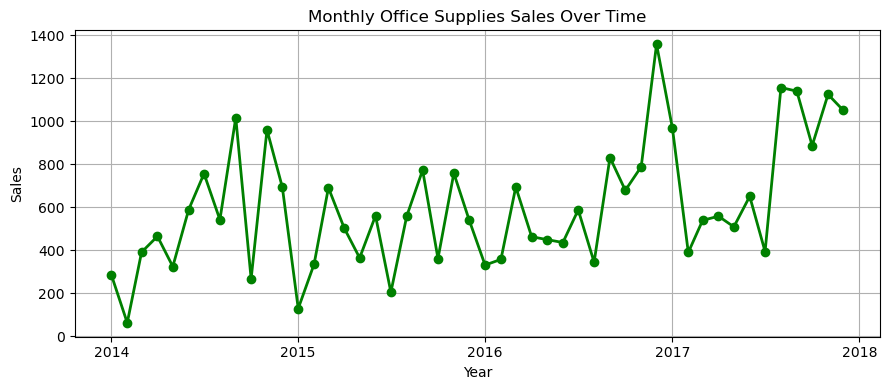

In [39]:
#visual of monthly trends over the years

plt.figure(figsize=(9,4))
plt.plot(y, color='green',linewidth=2, markersize=6, marker = 'o')


# Formating x-axis to show only years
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.title('Monthly Office Supplies Sales Over Time')
plt.xlabel('Year')
plt.ylabel('Sales')
plt.grid(True)
plt.tight_layout()
plt.show()


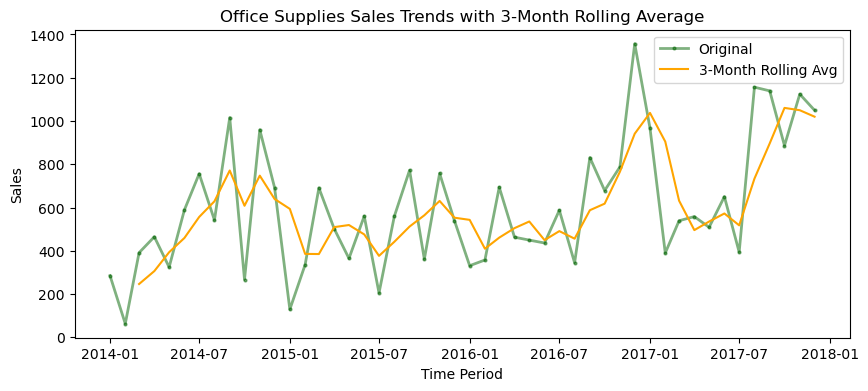

In [105]:
y_rolling = y.rolling(window=3).mean()

plt.figure(figsize=(10,4))
plt.plot(y, label='Original', alpha=0.5 , color = 'darkgreen', linewidth = 2, markersize=2, marker = 'o')
plt.plot(y_rolling, label='3-Month Rolling Avg', color='orange')
plt.title('Office Supplies Sales Trends with 3-Month Rolling Average')
plt.xlabel('Time Period')
plt.ylabel('Sales')
plt.legend()
plt.savefig('Office-supplies-sales-with-rolling-average')
plt.show()


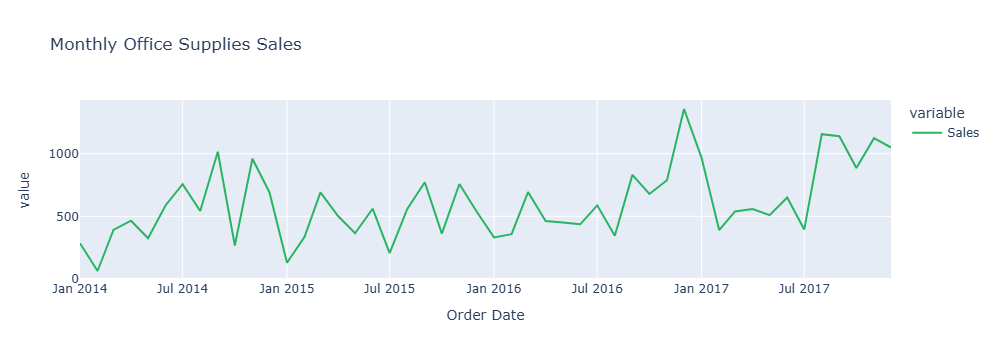

In [45]:
#interactive plot

import plotly.express as px

fig = px.line(y, title='Monthly Office Supplies Sales',

    line_shape='linear',
    color_discrete_sequence=['#28B463'])

fig.show()


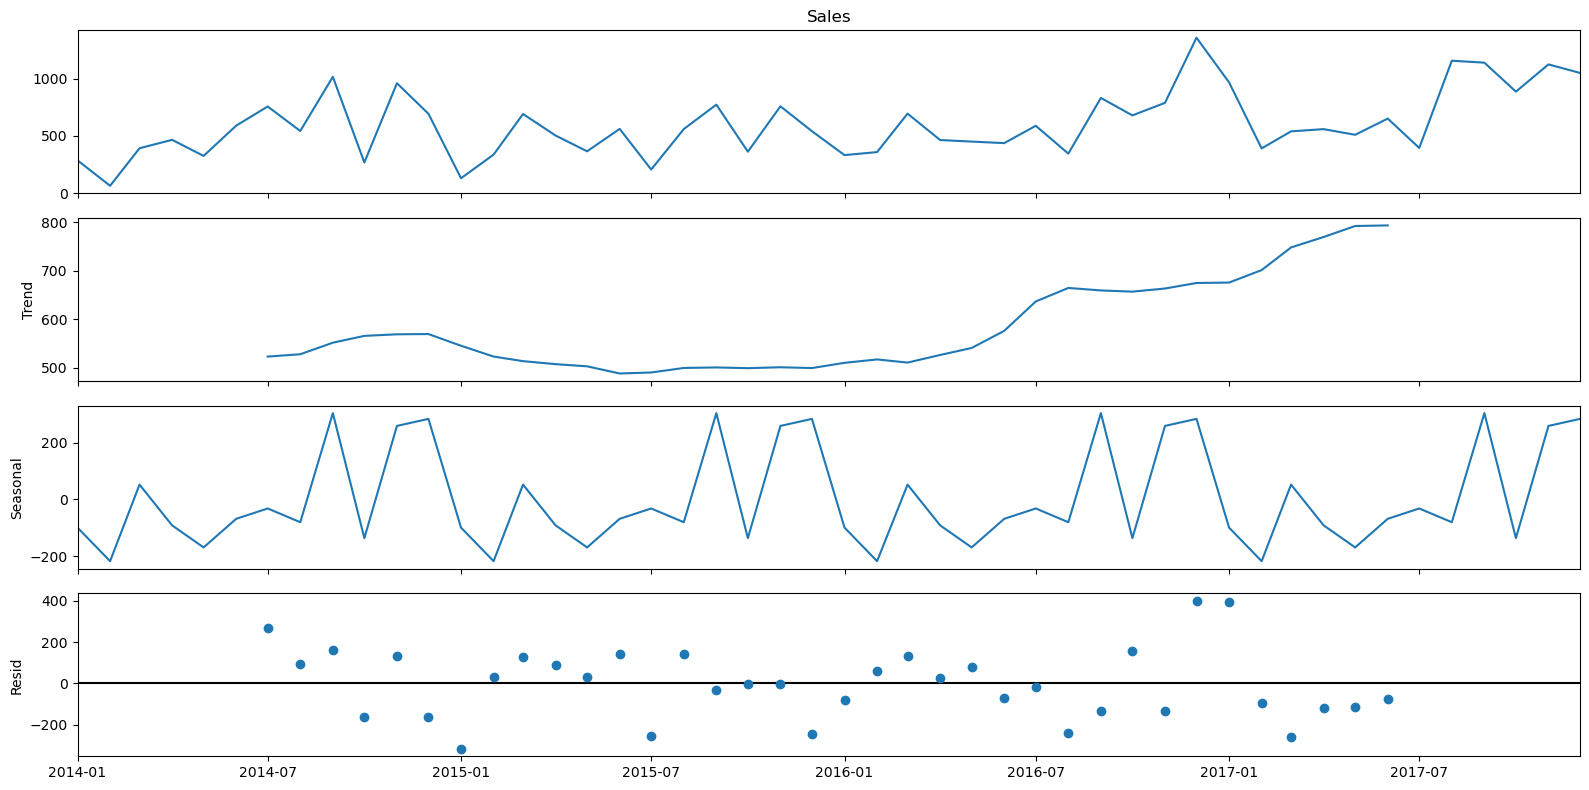

In [49]:


from pylab import rcParams
rcParams['figure.figsize'] = 16, 8

decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.tight_layout()
plt.show()


#plot shows unstable sales and is seasonal

# Autoregressive Integrated Moving Average (ARIMA)

* Commonly used method for time-series forcasting
* AR uses past values to predict future ones (high sales in 1 month might indicate high next month)
* Integrated makes the data stable by removing trends (differencing) and helps the model to focus on patterns, not just upward or downward drift.
* MA uses past errors (how wrong predictions were) to improve future forecasts.

* ARIMA is good for non-seasonal time series with clear patterns
* For seasonal data SARIMA could be used (like monthly sales spikes)
* Useful to make data driven decisions

  # Why use ARIMA
  * It helps to forecast monthly sales by learning from past patterns and adjusting for seasonality

# Seasonal ARIMA 
* Used for forecasting time series data with seasonality like monthly office supplies sales.
* The below code is used for grid search, testing multiple parameter combinations to find the best-fitting SARIMA model.


In [31]:
p = d = q = range(0, 2) #parameters 'p' AR, 'd' differencing (to make data statinary), 'q' moving average terms
# 0 to 1 range for a simple grid search


pdq = list(itertools.product(p, d, q)) #creating all combinations
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))] #adds seasonality to each combination. 12 months

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [33]:
# GRID SEARCH to find the best SARIMA model
# loops through all combinations of non-seasonal(param) and seasonal(param_seasonal) ARIMA parameters

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,   #for each season builds a model
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:747.1990404227043
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1522.1937939097666
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:500.73353987806166
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:333.7101496510543


C:\Users\Zubeen\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Zubeen\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:516.0876543936834
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1549.9741487628855
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:347.44488563489716


C:\Users\Zubeen\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Zubeen\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:335.9078573355651
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:702.6891395292467
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2762.510813550018
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:487.7601415814735


C:\Users\Zubeen\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Zubeen\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:319.862595727915
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:517.4952646587356
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2591.150822929763


C:\Users\Zubeen\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Zubeen\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:345.69220944601085
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:320.845077522024
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:666.4572044948625


C:\Users\Zubeen\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Zubeen\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1383.1479726152959
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:503.0840747554472
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:323.420104009395
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:500.0109385290892


C:\Users\Zubeen\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Zubeen\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:1643.68682191906
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:335.7148959418817
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:322.95954030915095
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:637.3530008828185


C:\Users\Zubeen\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Zubeen\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:1113.2450511293268
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:473.7153967455451
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:302.48088241055245
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:489.9419970027667
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:2240.9990280972897


C:\Users\Zubeen\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Zubeen\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:330.70615130932293
ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:303.76943584318195
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:680.4032716562346
ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:1360.1031628510557
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:501.7031226672368


C:\Users\Zubeen\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Zubeen\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:331.4711118149085
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:500.21905344214457


C:\Users\Zubeen\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Zubeen\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:1674.8647162571347
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:331.07199732550987
ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:332.9374884385164
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:651.1768264308226


C:\Users\Zubeen\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Zubeen\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:1927.106470766415
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:488.4314196132801
ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:317.77404794093985
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:489.2546400443082
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:2641.1481093770385
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:331.713680227356


C:\Users\Zubeen\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:318.34189985347535
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:658.0713305703065
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:33153230929467.18
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:494.907679737394
ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:321.10489100797423


C:\Users\Zubeen\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:482.8083753024955


C:\Users\Zubeen\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Zubeen\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:1373.304173383298
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:321.2325469884873
ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:321.39217693276476
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:638.7962401173074


C:\Users\Zubeen\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Zubeen\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:2553.4454620082606
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:475.7138851956536
ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:304.23429887457894
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:478.6987301743793
ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:275.51941737964034


C:\Users\Zubeen\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:318.2066479084283


C:\Users\Zubeen\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:305.3485156756031


In [35]:
print(results.mle_retvals)

# output shows that the model successfully found optimal parameters
# fopt: Final value of the objective function (lower is better but context matters too)
# gopt: Gradient values near zero shows stable and well optimized model
# fcalls: 252 function evaluations during optimization
# iterations: 36 No. of iterations it took to converge
# No warning raised during optimization

{'fopt': 3.0765470382875324, 'gopt': array([-3.73567843e-07,  3.15525384e-07, -1.08890674e-07, -1.12532206e-07,
        2.30926389e-09]), 'fcalls': 252, 'warnflag': 0, 'converged': True, 'iterations': 36}


Model is ready and safe to use for forecasting

In [37]:
#parameter summary showing how well each component contributes to forecasting time series

mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1), #(p,d,q)
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit() #fits the model to data using maximum likelihood estimation

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2479      0.328      0.755      0.450      -0.395       0.891
ma.L1         -0.9389      0.462     -2.030      0.042      -1.845      -0.032
ar.S.L12      -0.6135      0.348     -1.762      0.078      -1.296       0.069
sigma2      7.421e+04   2.68e+04      2.768      0.006    2.17e+04    1.27e+05


# Insights from parameter summary

* ar.L1 (Autoregressive lag 1) Coefficient = 0.25 (weak positive influence from last month's value) p-value = 0.45 shows not statistically significant.
* ma.L1 (Moving average lag 1) Coefficient = -0.94 (strong correction based on last month's error) p-value = 0.042 shows statistically significant
* ar.S.L12 (Seasonal AR lag 12) Coefficient = -0.61 (moderate seasonal effect from same month last year) p-value = 0.078 shows boarderline significancee.
* sigma2 (Error Variace) 74,210 → reflects the variance of residuals. p-value = 0.006, so it's significant and model errors are measurable.


Low p-value helps the model make accurate predictions. Non-significant terms may be dropped or adjusted to simplify the model. Now is the time to decide if I want to tweak parameters or accept the model as is.

Changing some hyperparameters and using fewer lags as the above size was too short for the diagnostic plots to work so trying a simpler model

In [41]:
#parameter summary showing how well each component contributes to forecasting time series

mod = sm.tsa.statespace.SARIMAX(y,
                                order=(0, 1, 1), #(p,d,q)
                                seasonal_order=(0, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit() #fits the model to data using maximum likelihood estimation

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8884      0.097     -9.114      0.000      -1.080      -0.697
sigma2      8.684e+04    1.8e+04      4.829      0.000    5.16e+04    1.22e+05


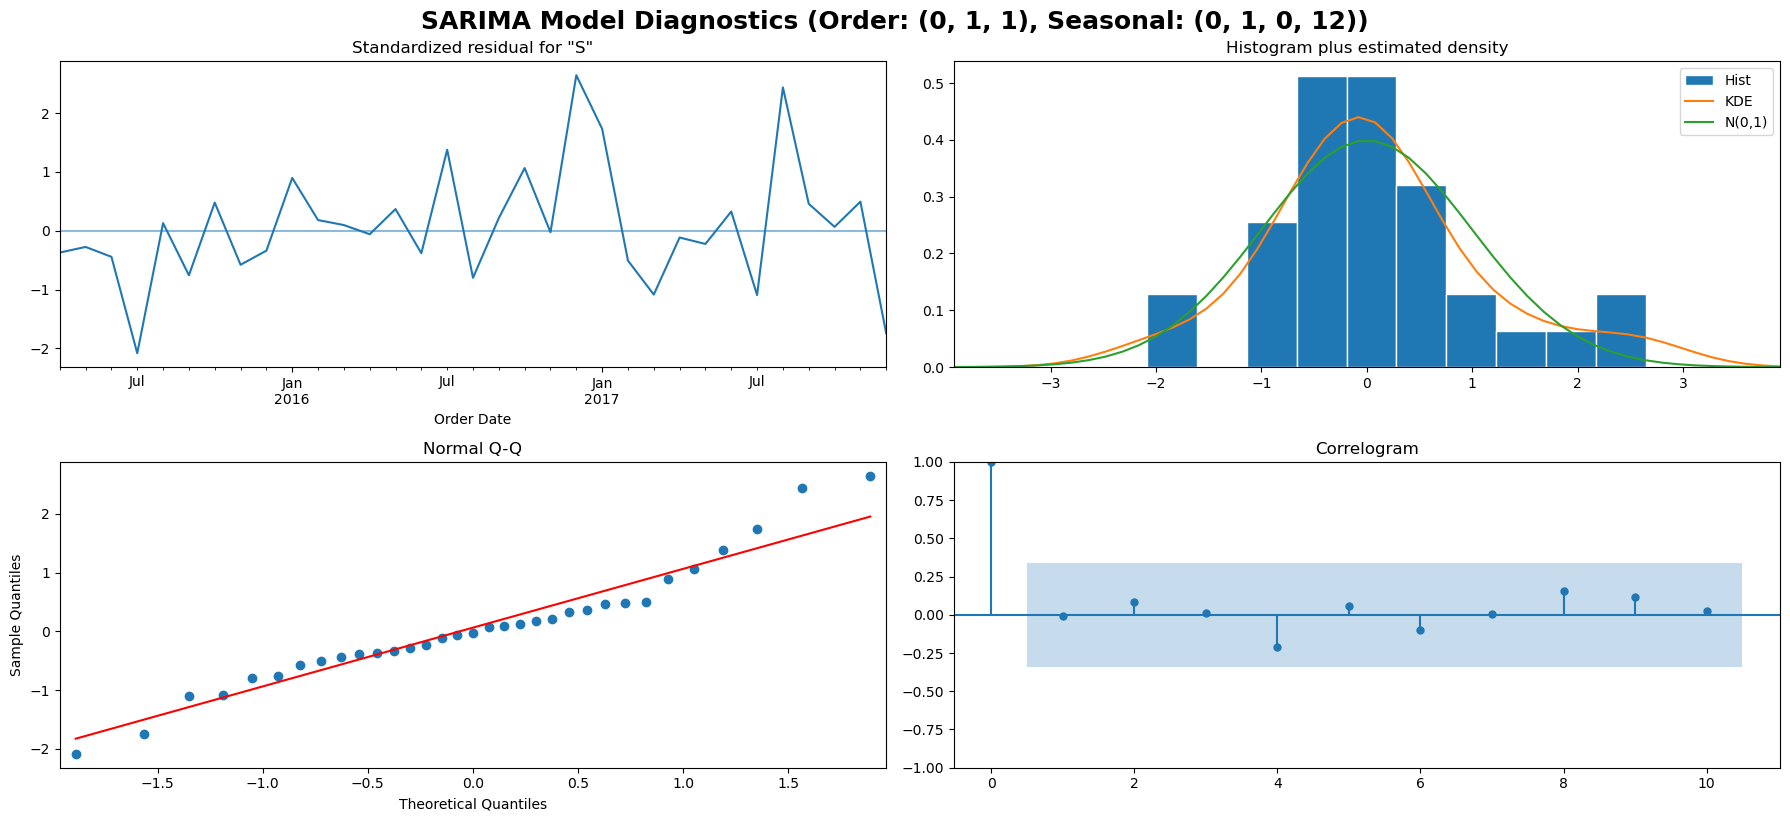

In [139]:
fig = results.plot_diagnostics(figsize=(18, 8))

plt.tight_layout()

fig.suptitle('SARIMA Model Diagnostics for Office Supplies', fontsize = 18, fontweight = 'bold', y= 1.02)
#model_title = ("SARIMA Model Diagnostics")
fig.suptitle(model_title, fontsize=18, fontweight='bold', y=1.02)

plt.savefig('SARIMA-Office-Supplies');



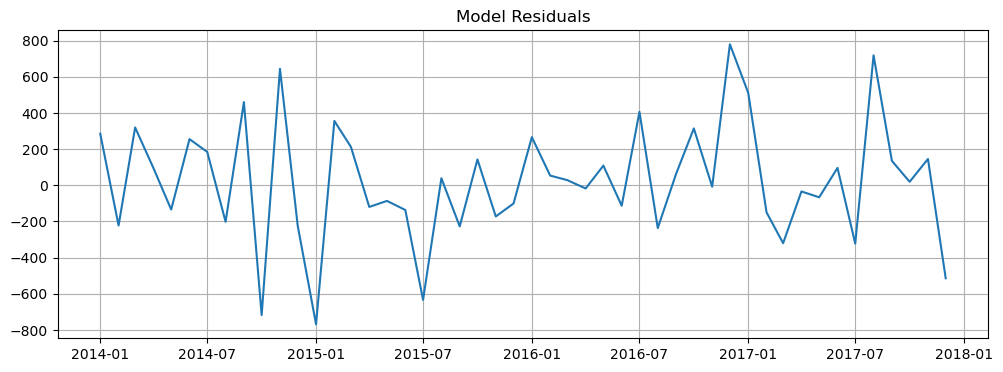

In [175]:
residuals = results.resid
plt.figure(figsize=(12,4))
plt.plot(residuals)
plt.title('Model Residuals')
plt.grid(True)
plt.show()


# Validating forecasts
To help us understand the accuracy of our forecasts, we compare predicted sales to real sales of the time series, and we set forecasts to start at 2017-07-01 to the end of the data Because dataset ends in Dec 2017 and starting the forecast mid-year gives 6 months of real data to compare against. This period also includes seasonal variations like summer dips and year end spikes

# The purpose of Forcast Validation is:
* Checking model accuracy by comparing predicted sales to actual sales
* To avoid overfitting as testing on unseen data to check how well the model generalizes
* To quantify errrors with metrics like MSE and RMSE help to measure how far off the predictions are.

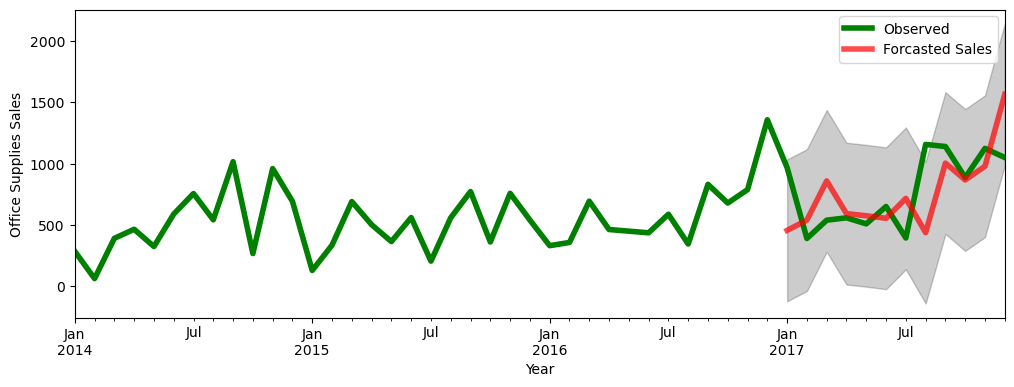

In [43]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic= False)
pred_ci = pred.conf_int()

ax = y['2014':].plot(label='Observed', linewidth = 4, color='green')
pred.predicted_mean.plot(ax=ax, label='Forcasted Sales', alpha=.7, figsize=(12, 4),linewidth = 4, color = 'red')

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Year')
ax.set_ylabel('Office Supplies Sales')
plt.legend()

plt.show()

# Insights:

The line plot is showing the observed values compared to the rolling forecast predictions. Overall, our forecasts align with the true values very well, showing an upward trend starts from the beginning of the year.

# Mean Squared Error (MSE)

In [45]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 110471.5


In [47]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 332.37


# Insights: 
* The MSE is an estimator that measures the average of the squares of the errors which is the average squared difference between the estimated and predicted.
* Overall it measures the quality of an estimator, it is always non-negative, and the smaller the MSE, the closer we can find the line of best fit.
* 
Root Mean Square Error (RMSE) tells us that our model was able to forecast the average daire sales in the test set withi332.3764 of the real sales. Ouoffice suppliesre daily sa is around £10,140.57g00. In my opinion, this is a pretty good model so fa

# Why the model is working robustly
* RMSE (Root Mean Squared Error): 332.37 This tells us that, on average, the model’s forecast is off by about 332 per day
* As daily sales fluctuate within a £10K range, an average error of 332 is just 3.3% of the full range.
* Based on seasonal spikes and natural variability in sales, the RMSE of 332 suggests that SARIMA model is capturing the core patterns well without overfitting.
* Overall, the model is reliable specially for operational planning or inventory decisions

# Summary:

To sum up, the SARIMA model forcasts office supplies sales with MSE of 110471.5,  translating to an average daily deviation of £332.37, just 3.3% of the observed sales range. This indicates strong alignment with historical patterns and reliable predictive performance. This level of precision enables confident planning across procurement and operations, while quantifying forecast uncertainty for risk-aware decision-making..

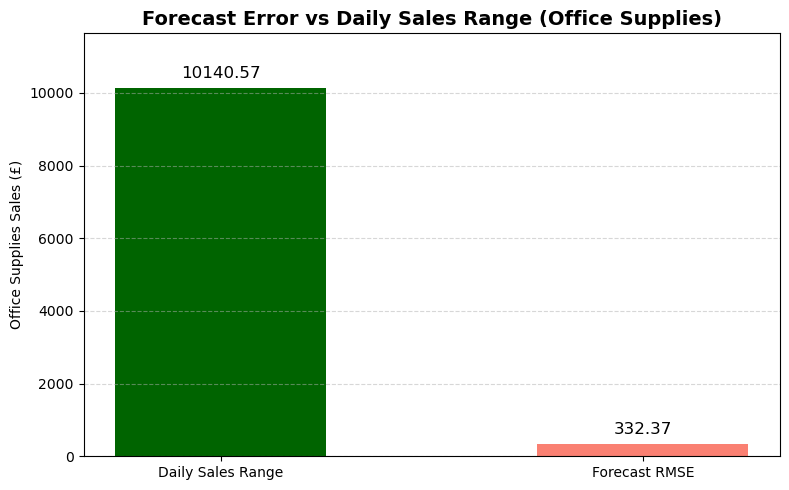

In [157]:
import matplotlib.pyplot as plt

# Values
daily_range = 10140.57
rmse = 332.37

# Plot
fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(['Daily Sales Range', 'Forecast RMSE'], [daily_range, rmse],
              color=['darkgreen', 'salmon'], width=0.5)

# Annotate bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 200,
            f'{height:.2f}', ha='center', va='bottom', fontsize=12)
plt.tight_layout()

ax.set_ylim(0, daily_range + 1500) #to leave space above bars
ax.set_title('Forecast Error vs Daily Sales Range (Office Supplies)', fontsize=14, fontweight='bold')
ax.set_ylabel('Office Supplies Sales (£)')
ax.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('Forecast-Error-vs-Daily-Sales-Range-(Office-Supplies)')
plt.show()


# Forcast for Office supplies sales

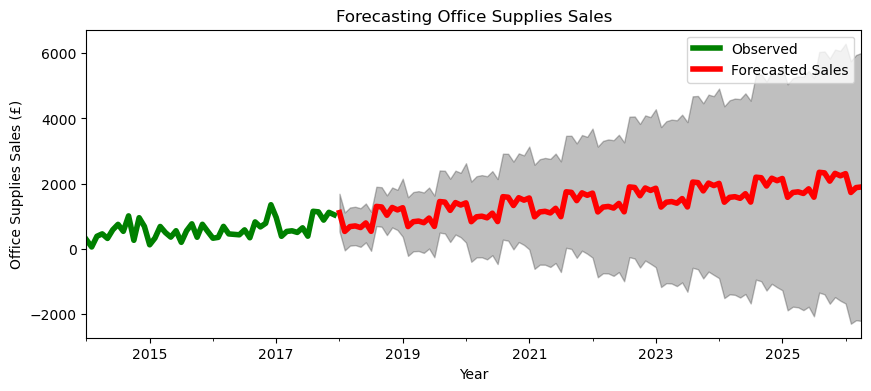

In [159]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()

ax = y.plot(label='Observed', figsize=(10, 4), color = 'green',linewidth = 4)
pred_uc.predicted_mean.plot(ax=ax, label='Forecasted Sales', linewidth = 4, color = 'red')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Year')
ax.set_ylabel('Office Supplies Sales (£)')
ax.set_title('Forecasting Office Supplies Sales')

plt.legend()
plt.savefig('Office-Sales-Forecast')
plt.show()

# Insights from forcast

The SARIMA model successfully captured seasonal patterns in office supplies sales, with forecast accuracy validated over a six-month test window. During this period, the model achieved a Root Mean Squared Error (RMSE) of £332.37 just 3.3% of the observed daily sales range (£10,140.57). This level of precision indicates strong alignment with historical trends. As forecasts extend further into the future, the model’s confidence intervals widen, reflecting a natural increase in uncertainty while maintaining credible directional insights.


# Comparison with other items in the sales dataset

In [49]:
furniture = sales_data.loc[sales_data['Category'] == 'Furniture']
office = sales_data.loc[sales_data['Category'] == 'Office Supplies']
tech = sales_data.loc[sales_data['Category'] == 'Technology']

In [51]:
furniture.shape, office.shape , tech.shape

((2121, 21), (6026, 21), (1847, 21))

In [53]:
sales_data['Category'].value_counts()

Category
Office Supplies    6026
Furniture          2121
Technology         1847
Name: count, dtype: int64

In [55]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
furniture.drop(cols, axis=1)
office.drop(cols, axis=1)
tech.drop(cols, axis=1)

furniture = furniture.sort_values('Order Date')
office = office.sort_values('Order Date')
tech = tech.sort_values('Order Date')

furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()
office = office.groupby('Order Date')['Sales'].sum().reset_index()
tech = tech.groupby('Order Date')['Sales'].sum().reset_index()

In [57]:
furniture.head()

Order Date     Sales
0 2014-01-06  2573.820
1 2014-01-07    76.728
2 2014-01-10    51.940
3 2014-01-11     9.940
4 2014-01-13   879.939

In [59]:
furniture = furniture.set_index('Order Date')
office = office.set_index('Order Date')
tech = tech.set_index('Order Date')
                          
y_furniture = furniture['Sales'].resample('MS').mean()
y_office = office['Sales'].resample('MS').mean()
y_tech = tech['Sales'].resample('MS').mean()

furniture = pd.DataFrame({'Order Date':y_furniture.index, 'Sales':y_furniture.values})
office = pd.DataFrame({'Order Date': y_office.index, 'Sales': y_office.values})
tech = pd.DataFrame({'Order Date': y_tech.index, 'Sales': y_tech.values})


store = furniture.merge(office, how='inner', on='Order Date')
store.rename(columns={'Sales_x': 'furniture_sales', 'Sales_y': 'office_sales'}, inplace=True)
store.head()

Order Date  furniture_sales  office_sales
0 2014-01-01       480.194231    285.357647
1 2014-02-01       367.931600     63.042588
2 2014-03-01       857.291529    391.176318
3 2014-04-01       567.488357    464.794750
4 2014-05-01       432.049188    324.346545

In [61]:
store.reset_index()

index Order Date  furniture_sales  office_sales
0       0 2014-01-01       480.194231    285.357647
1       1 2014-02-01       367.931600     63.042588
2       2 2014-03-01       857.291529    391.176318
3       3 2014-04-01       567.488357    464.794750
4       4 2014-05-01       432.049188    324.346545
5       5 2014-06-01       695.059242    588.774409
6       6 2014-07-01       601.169500    756.060400
7       7 2014-08-01       457.521656    541.879143
8       8 2014-09-01       992.353367   1015.677704
9       9 2014-10-01       769.015437    267.078815
10     10 2014-11-01       980.221486    959.372714
11     11 2014-12-01      1532.298325    692.556231
12     12 2015-01-01       978.328467    129.198571
13     13 2015-02-01       522.395667    335.504188
14     14 2015-03-01       781.236437    690.545522
15     15 2015-04-01       805.822962    502.342320
16     16 2015-05-01       624.996700    364.549440
17     17 2015-06-01       428.565500    560.407737
18     18 2015-07-01       719.706316    205.214739
19     19 2015-08-01       602.412012    558.814667
20     20 2015-09-01      1382.790684    772.230680
21     21 2015-10-01       632.980184    361.392083
22     22 2015-11-01      1286.701354    757.790357
23     23 2015-12-01      1049.355418    540.055800
24     24 2016-01-01       508.182867    331.230125
25     25 2016-02-01       356.868273    357.597368
26     26 2016-03-01       609.575810    693.877240
27     27 2016-04-01       695.373158    462.932478
28     28 2016-05-01       687.265227    449.489724
29     29 2016-06-01       816.910750    436.072400
30     30 2016-07-01       768.736412    587.474727
31     31 2016-08-01       734.307782    344.605385
32     32 2016-09-01      1135.953371    830.847786
33     33 2016-10-01       624.872474    678.408083
34     34 2016-11-01      1271.345152    787.972231
35     35 2016-12-01      1410.719808   1357.055929
36     36 2017-01-01       397.602133    967.013136
37     37 2017-02-01       528.179800    389.882737
38     38 2017-03-01       544.672240    538.899481
39     39 2017-04-01       453.297905    558.229296
40     40 2017-05-01       678.302328    508.776444
41     41 2017-06-01       826.460291    650.463038
42     42 2017-07-01       562.524857    393.902615
43     43 2017-08-01       857.881889   1156.148154
44     44 2017-09-01      1209.508583   1139.137250
45     45 2017-10-01       875.362728    886.045846
46     46 2017-11-01      1277.817759   1124.012036
47     47 2017-12-01      1256.298672   1049.549724

In [63]:
store = store.merge(tech, how='inner', on='Order Date')

In [65]:

store = store.rename(columns={'Sales':'technology_sales'})
store.head()

Order Date  furniture_sales  office_sales  technology_sales
0 2014-01-01       480.194231    285.357647        449.041429
1 2014-02-01       367.931600     63.042588        229.787143
2 2014-03-01       857.291529    391.176318       2031.948375
3 2014-04-01       567.488357    464.794750        613.028933
4 2014-05-01       432.049188    324.346545        564.698588

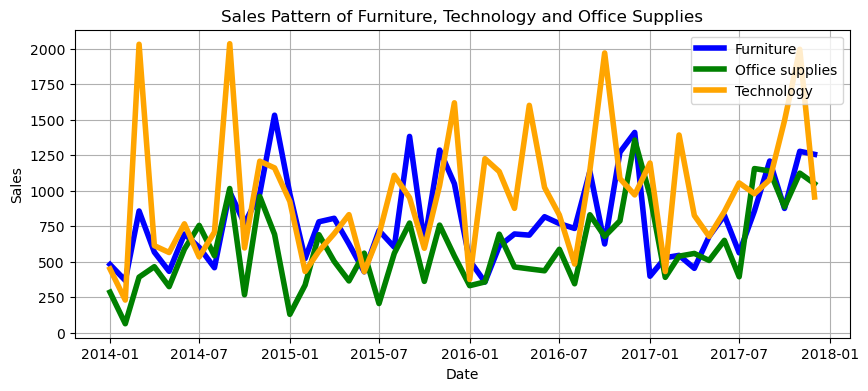

In [125]:
plt.figure(figsize=(10, 4))
plt.plot(store['Order Date'], store['furniture_sales'], 'b-', label = 'Furniture',linewidth = 4)
plt.plot(store['Order Date'], store['office_sales'], 'green', label = 'Office supplies', linewidth = 4)
plt.plot(store['Order Date'], store['technology_sales'], 'orange', label = 'Technology', linewidth = 4)
plt.xlabel('Date'); plt.ylabel('Sales'); plt.title('Sales Pattern of Furniture, Technology and Office Supplies')
plt.grid()
plt.legend()
plt.savefig('category-comparison-sales');

# Insights:

In [69]:
first_index = (store['furniture_sales'] > store['technology_sales']).idxmax()
first_date = store.loc[first_index, 'Order Date']

print("Furniture first time produced higher sales than technology is {}.".format(first_date.date()))

Furniture first time produced higher sales than technology is 2014-01-01.


In [71]:
first_index = np.min(np.where(store['office_sales'] > store['furniture_sales'])[0])
first_date = store.loc[first_index, 'Order Date']

print("Office supplies first time produced higher sales than furniture is {}.".format(first_date.date()))



Office supplies first time produced higher sales than furniture is 2014-07-01.


It was July 2014 when office supplies produced higher sales than furniture

In [170]:
office.columns

Index(['level_0', 'index', 'ds', 'y', 'Year', 'Month'], dtype='object')

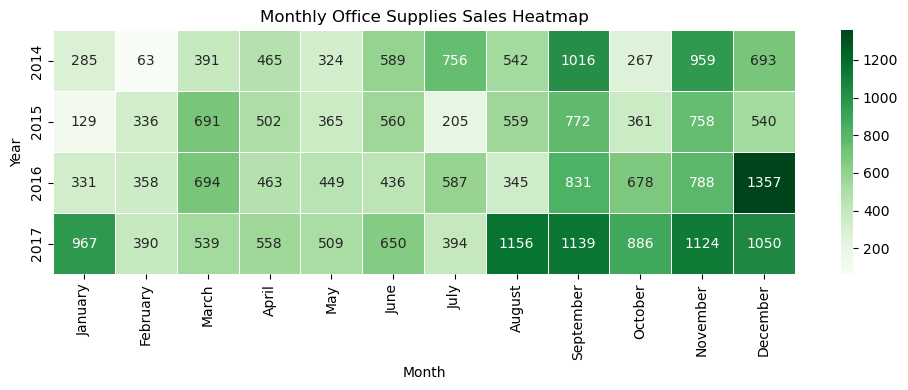

In [73]:
# datetime index
office = office.reset_index()
office['Year'] = office['Order Date'].dt.year
office['Month'] = office['Order Date'].dt.month_name()

# Making Pivot table for heatmap
heatmap_data = office.pivot_table(index='Year', columns='Month', values='Sales', aggfunc='sum')

# Sort months chronologically
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']
heatmap_data = heatmap_data[month_order]

# Plot heatmap
plt.figure(figsize=(10, 4))
sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap="Greens", linewidths=0.5)
plt.title("Monthly Office Supplies Sales Heatmap")
plt.xlabel("Month")
plt.ylabel("Year")
plt.tight_layout()
plt.savefig('Office-Supplies-Heatmap')
plt.show()


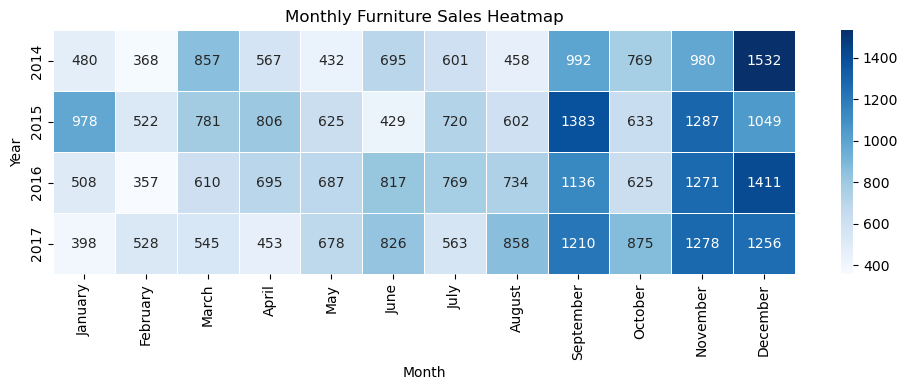

In [75]:
# datetime index
furniture = furniture.reset_index()
furniture['Year'] = furniture['Order Date'].dt.year
furniture['Month'] = furniture['Order Date'].dt.month_name()

# Making Pivot table for heatmap
heatmap_data = furniture.pivot_table(index='Year', columns='Month', values='Sales', aggfunc='sum')

# Sort months chronologically
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']
heatmap_data = heatmap_data[month_order]

# Plot heatmap
plt.figure(figsize=(10, 4))
sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap="Blues", linewidths=0.5)
plt.title("Monthly Furniture Sales Heatmap")
plt.xlabel("Month")
plt.ylabel("Year")
plt.tight_layout()
plt.savefig('monthly-furniture-heatmap')
plt.show()

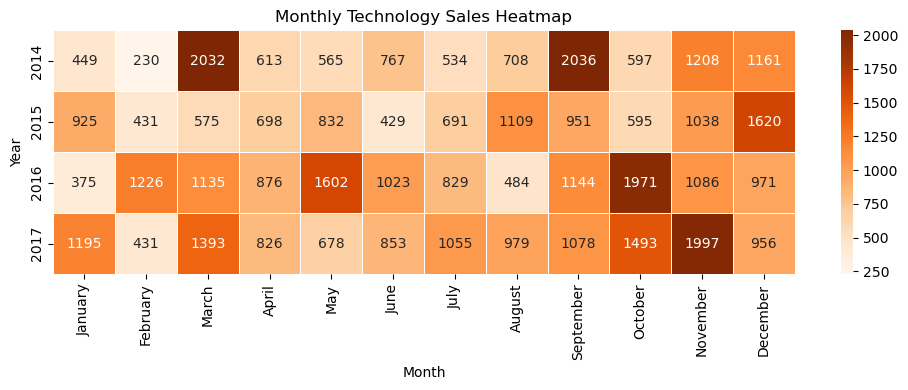

In [77]:
# datetime index
tech = tech.reset_index()
tech['Year'] = tech['Order Date'].dt.year
tech['Month'] = tech['Order Date'].dt.month_name()

# Making Pivot table for heatmap
heatmap_data = tech.pivot_table(index='Year', columns='Month', values='Sales', aggfunc='sum')

# Sort months chronologically
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']
heatmap_data = heatmap_data[month_order]

# Plot heatmap
plt.figure(figsize=(10, 4))
sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap="Oranges", linewidths=0.5)
plt.title("Monthly Technology Sales Heatmap")
plt.xlabel("Month")
plt.ylabel("Year")
plt.tight_layout()
plt.savefig('monthly-tech-heatmap')
plt.show()

# Time Series Modeling with Prophet
Released by Facebook in 2017, forecasting tool Prophet is designed for analszing time-series that display patterns on different time scales such as yearly, weekly and daily. It also has advanced capabilities for modeling the effects of holidays on a time-series and implementing custom changepoints. Therefore,it's good to use  Prophet to get a model up and running.

In [38]:
!pip install prophet

  Using cached holidays-0.82-py3-none-any.whl.metadata (49 kB)
   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/13.3 MB 991.0 kB/s eta 0:00:14
    --------------------------------------- 0.2/13.3 MB 2.1 MB/s eta 0:00:07
    --------------------------------------- 0.3/13.3 MB 2.5 MB/s eta 0:00:06
   - -------------------------------------- 0.5/13.3 MB 2.6 MB/s eta 0:00:06
   - -------------------------------------- 0.6/13.3 MB 2.8 MB/s eta 0:00:05
   -- ------------------------------------- 0.8/13.3 MB 2.8 MB/s eta 0:00:05
   -- ------------------------------------- 0.9/13.3 MB 3.0 MB/s eta 0:00:05
   --- ------------------------------------ 1.1/13.3 MB 2.9 MB/s eta 0:00:05
   --- ------------------------------------ 1.2/13.3 MB 2.9 MB/s eta 0:00:05
   --- ------------------------------------ 1.3/13.3 MB 2.8 MB/s eta 0:00:05
   ---- ----------------------------------- 1.4/13.3 MB 2.8 MB/s eta 0:00:05
   ---- ----------

In [79]:
from prophet import Prophet

furniture = furniture.rename(columns={'Order Date': 'ds', 'Sales': 'y'})
furniture_model = Prophet(interval_width=0.95)
furniture_model.fit(furniture)

office = office.rename(columns={'Order Date': 'ds', 'Sales': 'y'})
office_model = Prophet(interval_width=0.95)
office_model.fit(office)

tech = tech.rename(columns={'Order Date': 'ds', 'Sales': 'y'})
tech_model = Prophet(interval_width=0.95)
tech_model.fit(tech)

17:00:10 - cmdstanpy - INFO - Chain [1] start processing
17:00:10 - cmdstanpy - INFO - Chain [1] done processing
17:00:10 - cmdstanpy - INFO - Chain [1] start processing
17:00:10 - cmdstanpy - INFO - Chain [1] done processing
17:00:10 - cmdstanpy - INFO - Chain [1] start processing
17:00:11 - cmdstanpy - INFO - Chain [1] done processing


In [81]:
furniture_forecast = furniture_model.make_future_dataframe(periods=36, freq='MS')
furniture_forecast = furniture_model.predict(furniture_forecast)

office_forecast = office_model.make_future_dataframe(periods=36, freq='MS')
office_forecast = office_model.predict(office_forecast)

tech_forecast = tech_model.make_future_dataframe(periods=36, freq='MS')
tech_forecast = tech_model.predict(tech_forecast)

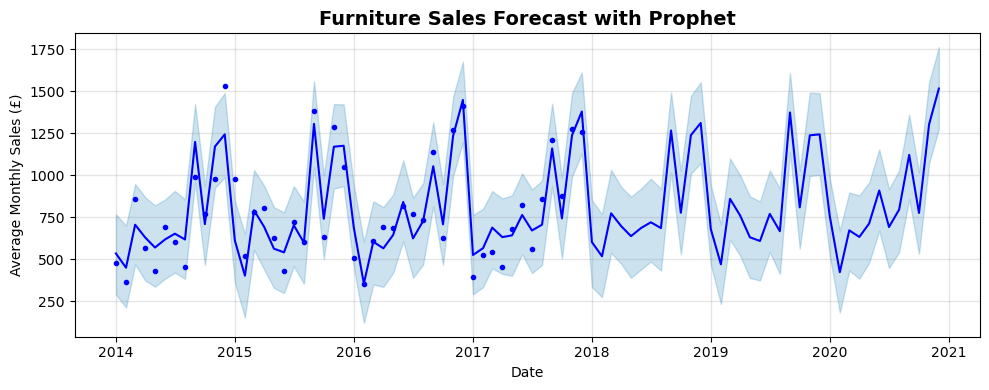

In [107]:
fig = furniture_model.plot(furniture_forecast)
ax = fig.gca()  # Get current axes
fig.set_size_inches(10,4)

# Change forecast line color
for line in ax.get_lines():
    line.set_color('Blue') 

# Customize title and labels
ax.set_title('Furniture Sales Forecast with Prophet', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Average Monthly Sales (£)')
plt.tight_layout()
plt.savefig('furniture-forcast-prophet')
plt.show()


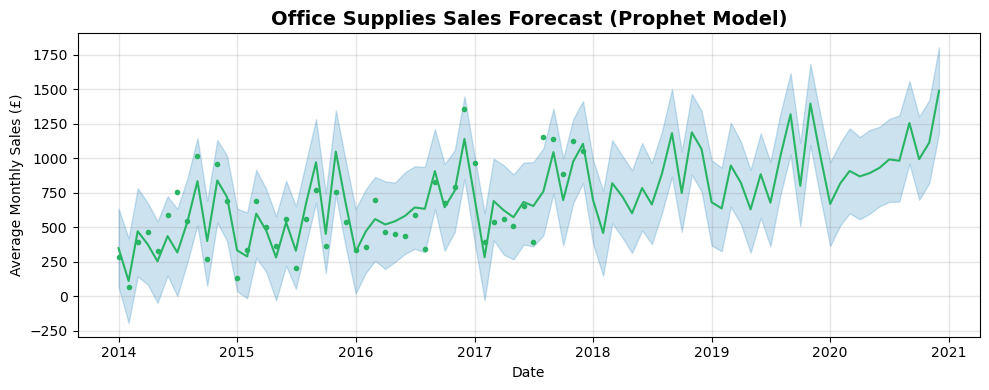

In [103]:
fig = office_model.plot(office_forecast)
ax = fig.gca()  # Get current axes

fig.set_size_inches(10,4)
# Change forecast line color
for line in ax.get_lines():
    line.set_color('#28B463')  # Replace with your preferred color

# Customize title and labels
ax.set_title('Office Supplies Sales Forecast (Prophet Model)', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Average Monthly Sales (£)')
plt.tight_layout()
plt.savefig('Office-Forecast-Prophet-Model')
plt.show()

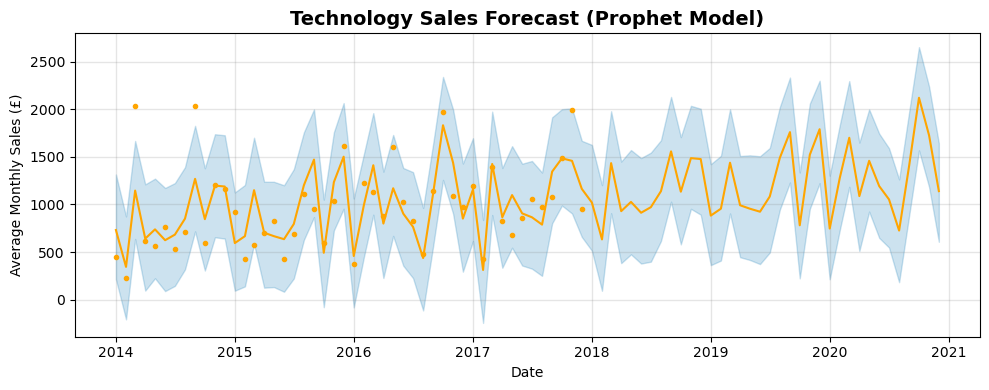

In [116]:
fig = tech_model.plot(tech_forecast)
ax = fig.gca()  # Get current axes

fig.set_size_inches(10,4)
# Change forecast line color
for line in ax.get_lines():
    line.set_color('Orange') 

# Customize title and labels
ax.set_title('Technology Sales Forecast (Prophet Model)', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Average Monthly Sales (£)')
plt.tight_layout()
plt.savefig('tech-forecast-Prophet-Model')
plt.show()

# Compare Forecasts
We already have the forecasts for three years,l now join them together to compare their future forecasts.

In [85]:
furniture_names = ['furniture_%s' % column for column in furniture_forecast.columns]
office_names = ['office_%s' % column for column in office_forecast.columns]

merge_furniture_forecast = furniture_forecast.copy()
merge_office_forecast = office_forecast.copy()

merge_furniture_forecast.columns = furniture_names
merge_office_forecast.columns = office_names

forecast = pd.merge(merge_furniture_forecast, merge_office_forecast, how = 'inner', left_on = 'furniture_ds', right_on = 'office_ds')

forecast = forecast.rename(columns={'furniture_ds': 'Date'}).drop('office_ds', axis=1)
forecast.head()

Date  furniture_trend  furniture_yhat_lower  furniture_yhat_upper  \
0 2014-01-01       726.058109            291.703809            768.393924   
1 2014-02-01       727.494421            213.972389            700.606193   
2 2014-03-01       728.791734            470.591903            947.682072   
3 2014-04-01       730.228046            374.535809            869.632194   
4 2014-05-01       731.618025            337.843381            821.268388   

   furniture_trend_lower  furniture_trend_upper  furniture_additive_terms  \
0             726.058109             726.058109               -190.686099   
1             727.494421             727.494421               -276.379157   
2             728.791734             728.791734                -22.388253   
3             730.228046             730.228046               -100.140909   
4             731.618025             731.618025               -160.818882   

   furniture_additive_terms_lower  furniture_additive_terms_upper  \
0                     -190.686099                     -190.686099   
1                     -276.379157                     -276.379157   
2                      -22.388253                      -22.388253   
3                     -100.140909                     -100.140909   
4                     -160.818882                     -160.818882   

   furniture_yearly  ...  office_additive_terms  office_additive_terms_lower  \
0       -190.686099  ...            -140.041115                  -140.041115   
1       -276.379157  ...            -385.677761                  -385.677761   
2        -22.388253  ...             -31.378526                   -31.378526   
3       -100.140909  ...            -134.290665                  -134.290665   
4       -160.818882  ...            -263.823552                  -263.823552   

   office_additive_terms_upper  office_yearly  office_yearly_lower  \
0                  -140.041115    -140.041115          -140.041115   
1                  -385.677761    -385.677761          -385.677761   
2                   -31.378526     -31.378526           -31.378526   
3                  -134.290665    -134.290665          -134.290665   
4                  -263.823552    -263.823552          -263.823552   

   office_yearly_upper  office_multiplicative_terms  \
0          -140.041115                          0.0   
1          -385.677761                          0.0   
2           -31.378526                          0.0   
3          -134.290665                          0.0   
4          -263.823552                          0.0   

   office_multiplicative_terms_lower  office_multiplicative_terms_upper  \
0                                0.0                                0.0   
1                                0.0                                0.0   
2                                0.0                                0.0   
3                                0.0                                0.0   
4                                0.0                                0.0   

   office_yhat  
0   347.489370  
1   109.240405  
2   470.212385  
3   374.687928  
4   252.304409  

[5 rows x 31 columns]

In [87]:

tech_names = ['tech_%s' % column for column in tech_forecast.columns]
merge_tech_forecast = tech_forecast.copy()
merge_tech_forecast.columns = tech_names

# Merge with existing forecast
forecast = pd.merge(forecast, merge_tech_forecast, how='inner', left_on='Date', right_on='tech_ds')

# Clean up column names
forecast = forecast.drop('tech_ds', axis=1)


In [63]:
forecast.head()

Date  furniture_trend  furniture_yhat_lower  furniture_yhat_upper  \
0 2014-01-01       726.058109            280.328583            779.737751   
1 2014-02-01       727.494421            217.754179            710.422305   
2 2014-03-01       728.791734            478.987565            951.716335   
3 2014-04-01       730.228046            375.465987            853.809990   
4 2014-05-01       731.618025            320.521160            797.933168   

   furniture_trend_lower  furniture_trend_upper  furniture_additive_terms  \
0             726.058109             726.058109               -190.686099   
1             727.494421             727.494421               -276.379157   
2             728.791734             728.791734                -22.388253   
3             730.228046             730.228046               -100.140909   
4             731.618025             731.618025               -160.818882   

   furniture_additive_terms_lower  furniture_additive_terms_upper  \
0                     -190.686099                     -190.686099   
1                     -276.379157                     -276.379157   
2                      -22.388253                      -22.388253   
3                     -100.140909                     -100.140909   
4                     -160.818882                     -160.818882   

   furniture_yearly  ...  tech_additive_terms  tech_additive_terms_lower  \
0       -190.686099  ...          -220.563518                -220.563518   
1       -276.379157  ...          -613.862382                -613.862382   
2        -22.388253  ...           181.796373                 181.796373   
3       -100.140909  ...          -328.518998                -328.518998   
4       -160.818882  ...          -237.337621                -237.337621   

   tech_additive_terms_upper  tech_yearly  tech_yearly_lower  \
0                -220.563518  -220.563518        -220.563518   
1                -613.862382  -613.862382        -613.862382   
2                 181.796373   181.796373         181.796373   
3                -328.518998  -328.518998        -328.518998   
4                -237.337621  -237.337621        -237.337621   

   tech_yearly_upper  tech_multiplicative_terms  \
0        -220.563518                        0.0   
1        -613.862382                        0.0   
2         181.796373                        0.0   
3        -328.518998                        0.0   
4        -237.337621                        0.0   

   tech_multiplicative_terms_lower  tech_multiplicative_terms_upper  \
0                              0.0                              0.0   
1                              0.0                              0.0   
2                              0.0                              0.0   
3                              0.0                              0.0   
4                              0.0                              0.0   

     tech_yhat  
0   731.791382  
1   344.613664  
2  1145.801199  
3   641.606975  
4   738.712044  

[5 rows x 46 columns]

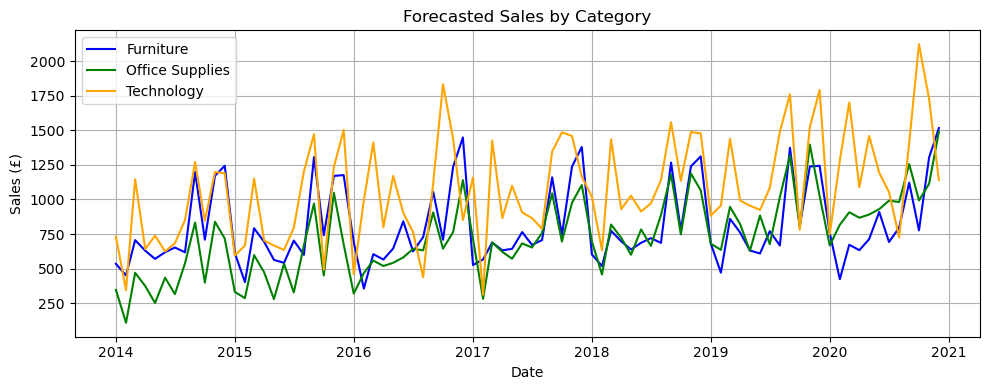

In [127]:
plt.figure(figsize=(10, 4))
plt.plot(forecast['Date'], forecast['furniture_yhat'], label='Furniture', color='blue')
plt.plot(forecast['Date'], forecast['office_yhat'], label='Office Supplies', color='green')
plt.plot(forecast['Date'], forecast['tech_yhat'], label='Technology', color='orange')
plt.title('Forecasted Sales by Category')
plt.xlabel('Date')
plt.ylabel('Sales (£)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('Forcasted-Sales-by-Category')
plt.show()


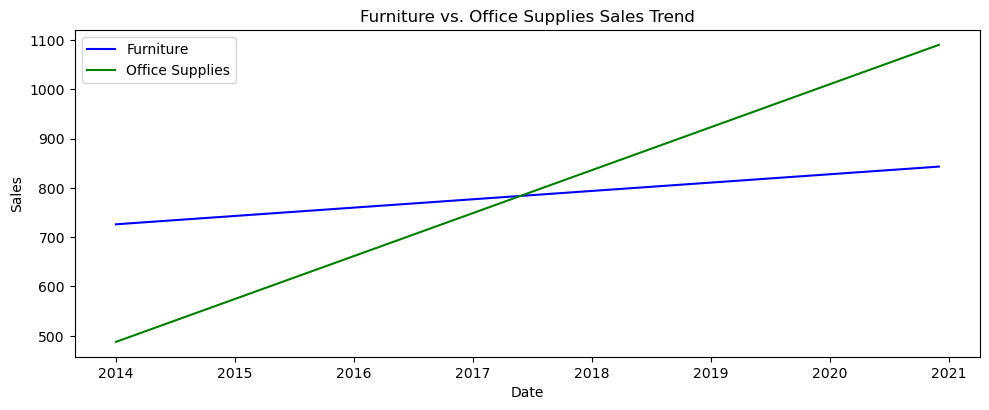

In [129]:
plt.figure(figsize=(10, 4))
plt.plot(forecast['Date'], forecast['furniture_trend'], 'b-', label = 'Furniture')
plt.plot(forecast['Date'], forecast['office_trend'], 'green', label = 'Office Supplies')

plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.tight_layout()
plt.title('Furniture vs. Office Supplies Sales Trend')
plt.savefig('Furniture-vs-Office-SalesTrends');

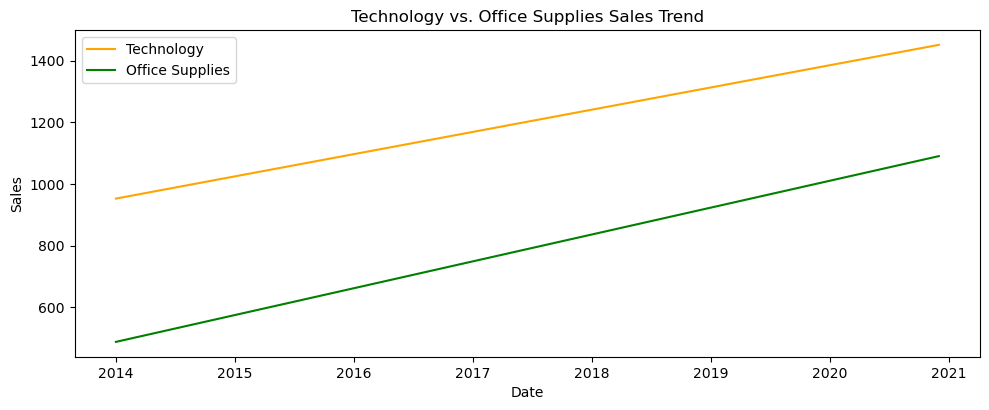

In [131]:
plt.figure(figsize=(10, 4))
plt.plot(forecast['Date'], forecast['tech_trend'], 'orange', label = 'Technology')
plt.plot(forecast['Date'], forecast['office_trend'], 'green', label = 'Office Supplies')

plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.tight_layout()
plt.title('Technology vs. Office Supplies Sales Trend')
plt.savefig('Tech-vs-Office-SalesTrends');

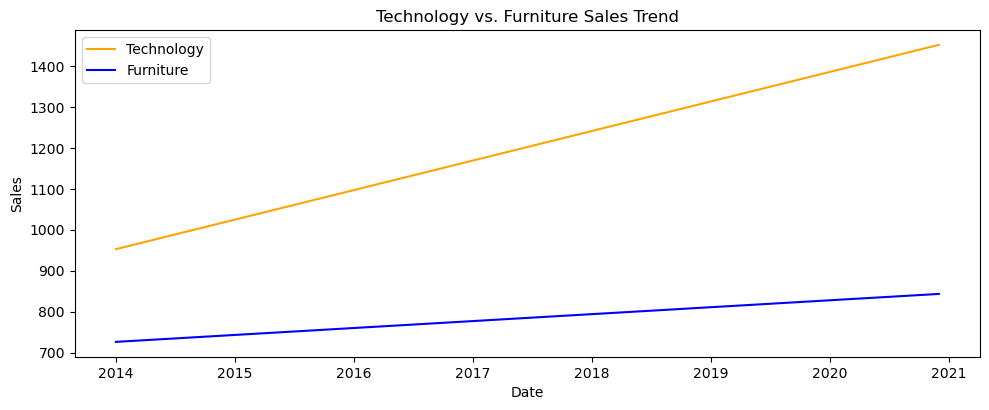

In [135]:
plt.figure(figsize=(10, 4))
plt.plot(forecast['Date'], forecast['tech_trend'], 'orange', label = 'Technology')
plt.plot(forecast['Date'], forecast['furniture_trend'], 'blue', label = 'Furniture')

plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.tight_layout()
plt.title('Technology vs. Furniture Sales Trend');

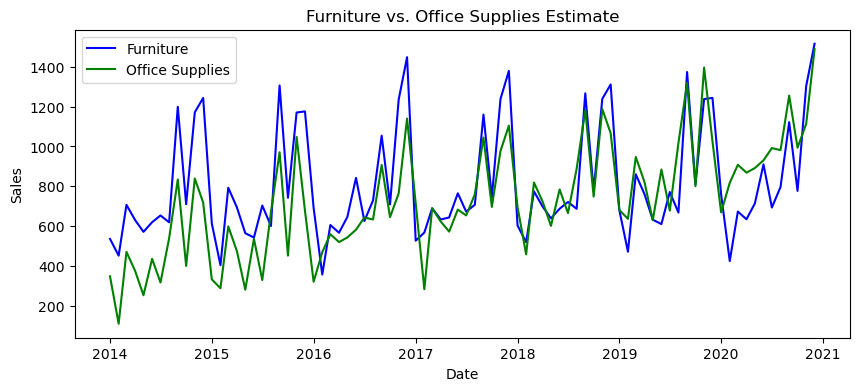

In [137]:
plt.figure(figsize=(10, 4))
plt.plot(forecast['Date'], forecast['furniture_yhat'], 'b-', label = 'Furniture')
plt.plot(forecast['Date'], forecast['office_yhat'], 'green', label = 'Office Supplies')
plt.legend(); plt.xlabel('Date'); plt.ylabel('Sales')
plt.title('Furniture vs. Office Supplies Estimate');

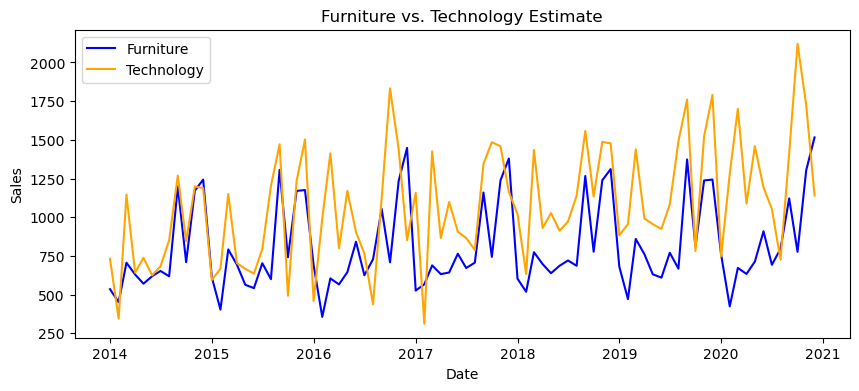

In [139]:
plt.figure(figsize=(10, 4))
plt.plot(forecast['Date'], forecast['furniture_yhat'], 'b-', label = 'Furniture')
plt.plot(forecast['Date'], forecast['tech_yhat'], 'orange', label = 'Technology')
plt.legend(); plt.xlabel('Date'); plt.ylabel('Sales')
plt.title('Furniture vs. Technology Sales Estimate');

# Trends and Patterns
No using  the Prophet Models to inspect different trends of theso categories in the data.



''

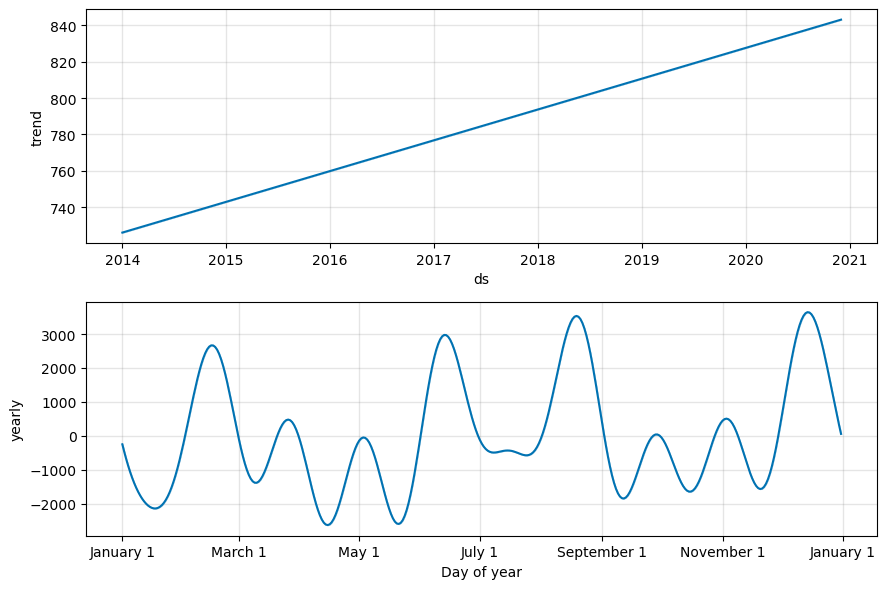

In [114]:
furniture_model.plot_components(furniture_forecast)
;
#plt.savefig('Furniture-Sales-Trend');

Furniture shows a steady upward trend with moderate seasonality. Peaks are visible aroung Q4, likely driven by year-end procurement or budget cycles. Overall it has stable revenue stream and is good for long-term contracts.

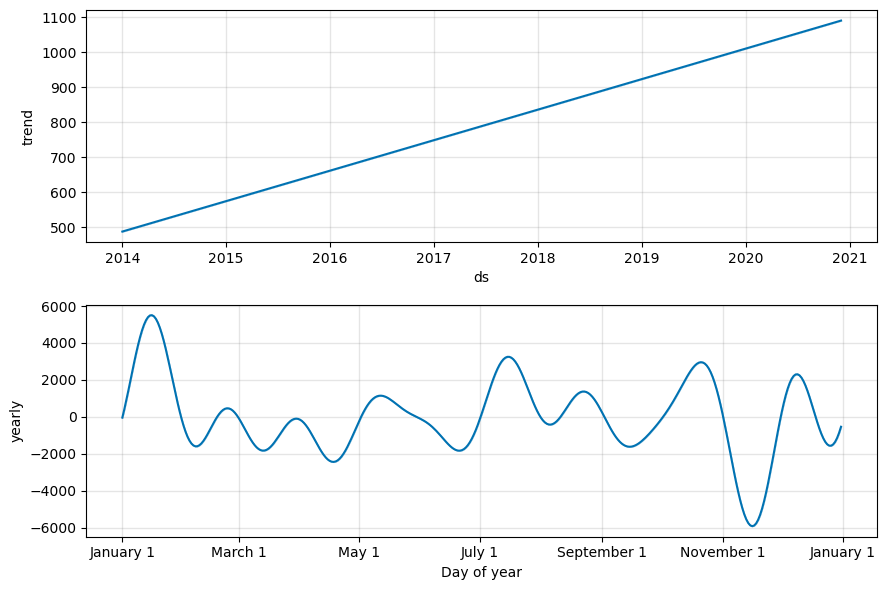

In [95]:
office_model.plot_components(office_forecast);

Office supplies exhibits sharper seasonal fluctuations, with notable spikes in August to December. This aligns with back-to-shool and fiscal year end purchasing.

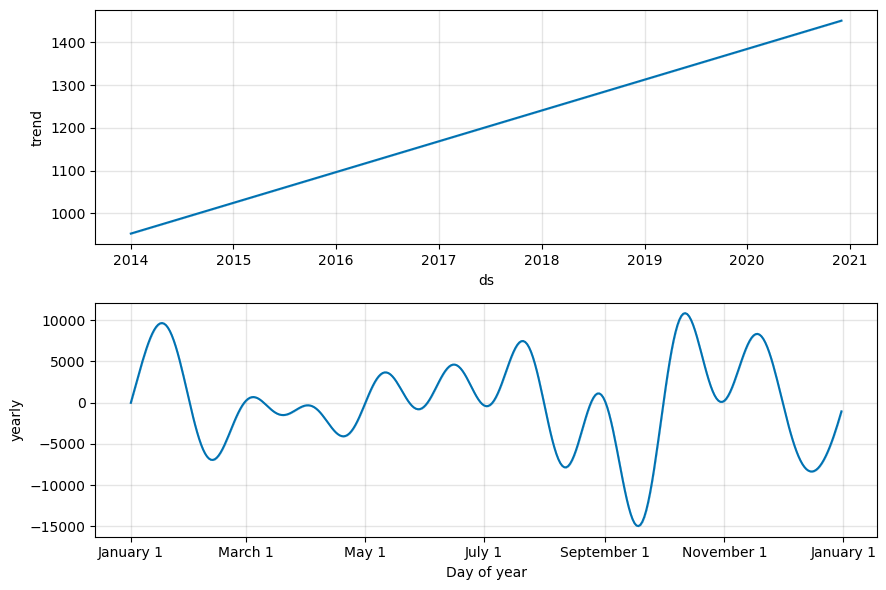

In [93]:
tech_model.plot_components(tech_forecast);

Tech has high peaks suggesting promotional cycles or one-off bulk purchases. High volatility requires agile inventory and marketing strategies.

# Insights: 

Our time series models forecast category-level sales with high precision and clear seasonal patterns. Office Supplies show strong Q4 spikes, Technology is volatile but high-yield, and Furniture remains stable. Forecast confidence intervals are tight for the next 6–12 months, supporting reliable planning. These insights enable targeted inventory, marketing, and procurement strategies across categories.

In [147]:
df.columns

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit'],
      dtype='object')

In [153]:
print(furniture.columns)


Index(['index', 'ds', 'y', 'Year', 'Month'], dtype='object')


In [91]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define consistent month order
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']

# Function to prepare heatmap data safely
def prepare_heatmap(df, category_name):
    df = df.copy()
    df['Year'] = df['Order Date'].dt.year
    df['Month'] = df['Order Date'].dt.month_name()
    pivot = df.pivot_table(index='Year', columns='Month', values='Sales', aggfunc='sum')
    pivot = pivot.reindex(columns=month_order)  # Safe reordering
    return pivot

# Prepare heatmap data
office_heatmap = prepare_heatmap(office, 'Office Supplies')
furniture_heatmap = prepare_heatmap(furniture, 'Furniture')
tech_heatmap = prepare_heatmap(tech, 'Technology')

# Plot side-by-side heatmaps
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

sns.heatmap(office_heatmap, annot=True, fmt=".0f", cmap="Oranges", linewidths=0.5, ax=axes[0])
axes[0].set_title("Office Supplies Sales", fontsize=14)

sns.heatmap(furniture_heatmap, annot=True, fmt=".0f", cmap="Blues", linewidths=0.5, ax=axes[1])
axes[1].set_title("Furniture Sales", fontsize=14)

sns.heatmap(tech_heatmap, annot=True, fmt=".0f", cmap="Greens", linewidths=0.5, ax=axes[2])
axes[2].set_title("Technology Sales", fontsize=14)

for ax in axes:
    ax.set_xlabel("Month")
    ax.set_ylabel("Year")

plt.suptitle(" Seasonal Sales Heatmaps by Category", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


KeyError: 'Order Date'